## Project Objective

The objective of this project is to **predict customer responses to promotions** using both historical transaction behavior and promotion characteristics. In a real-world business context, such a model helps marketing teams:

- Identify behavioral patterns
- Design personalized promotions
- Prioritize high-likelihood responders

Ultimately, this leads to **improved retention, activation, and return on investment (ROI).**

---

## Dataset Overview

The dataset spans **March 2012 to February 2013**, with **34,184,139** transaction records and consists of three key tables:

- **train_history / test_history**:  
  Contains customer interactions with promotions, including:
  - `user_id`, `store_id`, `promotion_id`, `region`, `promotion_date`
  - `active` (binary target; only in training set)

- **transactions**:  
  Detailed transaction-level data including:
  - `purchase_date`, `amount_spent`, `units`, `product_size`, `store_id`,  
    `brand`, `category`, `market_group`, `manufacturer`

- **promos**:  
  Promotion metadata:
  - `category`, `manufacturer`, `promotion_value`, `brand`, `quantity`

---

## Target Variable

- **`active`**  
  - `1` → Customer responded to the promotion  
  - `0` → Customer did not respond  

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
promos = pd.read_csv('/promos.csv.gz')
promos.head()

,promo,category,promoqty,manufacturer,promoval,brand
0,209524,51006740,1,1593002228,1.00,189092190
1,176321,42760698,1,1957688344,0.75,1386413202
2,17125,56844954,1,629075831,1.50,1429623935
3,177412,56844954,1,629075831,1.50,1429623935
4,69839,56844954,1,629075831,1.50,1429623935


In [ ]:
train_history = pd.read_csv('/train_history.csv.gz', parse_dates=['promodate'])
train_history.head()

,id,store,promo,region,promodate,active
0,115562959531,860548,176321,243820,2013-03-25,0.0
1,175261390705,625933,37568,191747,2013-03-15,0.0
2,273751574633,527828,209524,165933,2013-03-23,1.0
3,166923268906,1056730,214816,5506,2013-03-20,0.0
4,135410903443,241369,176321,278897,2013-03-25,0.0


In [76]:
train_history.isnull().sum()

,0
id,0
store,0
promo,0
region,0
promodate,0
active,0


In [ ]:
test_history = pd.read_csv('/test_history.csv.gz', parse_dates=['promodate'])
test_history.head()

,id,store,promo,region,promodate,active
0,250462324156,457755,96852,191747,2013-04-22,NaN
1,61214568335,740794,54956,203586,2013-04-23,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN
3,91546215019,876095,108237,323706,2013-04-24,NaN
4,220718580189,625933,222088,191747,2013-04-18,NaN


In [78]:
test_history.isnull().sum()

,0
id,0
store,0
promo,0
region,0
promodate,0
active,10000


In [79]:
transactions = pd.read_parquet(path + '/transactions.parquet')
transactions.head()

,id,store,market_group,category,manufacturer,brand,date,productsize,measure,qty,amt
0,31924309471,96431,360548,10881580,707582354,109487351,2012-03-06,28.00,OZ,1,2.69
1,31924309471,96431,80472,75959720,2052533430,254982935,2012-03-06,12.00,OZ,2,8.48
2,31924309471,96431,194893,80209099,1640770606,1252530761,2012-03-06,6.00,OZ,1,1.69
3,31924309471,96431,27828,10942974,946555356,2133681340,2012-03-06,0.75,LT,1,11.41
4,31924309471,96431,135933,64737859,700393013,221618334,2012-03-06,33.84,OZ,1,3.19


In [80]:
transactions.isnull().sum()

,0
id,0
store,0
market_group,0
category,0
manufacturer,0
brand,0
date,0
productsize,0
measure,971343
qty,0


In [81]:
train = train_history.merge(promos, on="promo", how="left")

In [82]:
active_dist = train['active'].value_counts(normalize=True).rename_axis('active').reset_index(name='percentage')
active_dist['percentage'] = (active_dist['percentage'] * 100).round(2)
print(active_dist)


   active  percentage
0     0.0       79.75
1     1.0       20.25


In [83]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34184139 entries, 0 to 34184138
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   store         int64         
 2   market_group  int64         
 3   category      int64         
 4   manufacturer  int64         
 5   brand         int64         
 6   date          datetime64[ns]
 7   productsize   float32       
 8   measure       object        
 9   qty           int64         
 10  amt           float32       
dtypes: datetime64[ns](1), float32(2), int64(7), object(1)
memory usage: 2.5+ GB


In [84]:
print("Transaction date range:")
print("Min date:", transactions['date'].min())
print("Max date:", transactions['date'].max())


Transaction date range:
Min date: 2012-03-02 00:00:00
Max date: 2013-02-28 00:00:00


# Extract Features

## Compute Features

In [85]:
# RFM
max_date = transactions['date'].max()
transactions['last_purchase_days'] = (max_date - transactions['date']).dt.days

rfm = (
    transactions
    .groupby('id')
    .agg(
        recency=('last_purchase_days', 'min'),
        first_date=('date', 'min'),
        txn_count=('date', 'nunique'),
        monetary=('amt', 'sum')
    )
    .reset_index()
)
rfm['frequency'] = (
    rfm['txn_count'] /
    ((max_date - rfm['first_date']).dt.days.clip(lower=1))
)
rfm = rfm.drop(columns=['first_date', 'txn_count'])

In [86]:
visits = transactions.groupby(['id', 'date'])['amt'].sum().reset_index()
avg_amt_df       = visits.groupby('id')['amt'].mean().rename('avg_amt_per_visit').reset_index()
tot_txns_df      = transactions.groupby('id').size().rename('total_txns').reset_index()
tot_amt_df       = transactions.groupby('id')['amt'].sum().rename('total_amt').reset_index()
store_div_df     = transactions.groupby('id')['store'].nunique().rename('num_stores_visited').reset_index()


In [87]:
# Merge user-level features into `train`
train = (
    train
    .merge(rfm,           on='id', how='left')
    .merge(avg_amt_df,    on='id', how='left')
    .merge(tot_txns_df,   on='id', how='left')
    .merge(tot_amt_df,    on='id', how='left')
    .merge(store_div_df,  on='id', how='left')
)


In [88]:
# Days between last purchase and promo date
last_txn_df = transactions.groupby('id')['date'].max().rename('last_txn_date').reset_index()
train = train.merge(last_txn_df, on='id', how='left')
train['days_between_last_txn_promo'] = (
    (train['promodate'] - train['last_txn_date']).dt.days.fillna(-1)
)
train = train.drop(columns=['last_txn_date'])


In [89]:
# Offer value ratio
train['value_to_basket_ratio'] = (
    (train['promoval'] / train['avg_amt_per_visit'])
    .replace([np.inf, -np.inf], 0)
    .fillna(0)
)

In [90]:
# Recent activity (last 30 days before promo)
promo_df   = train[['id','promodate']]
txn_promo  = transactions.merge(promo_df, on='id', how='left')
txn_promo['days_before_promo'] = (txn_promo['promodate'] - txn_promo['date']).dt.days

recent30_df = (
    txn_promo
    .query('0 <= days_before_promo <= 30')
    .groupby(['id','promodate'])
    .size()
    .rename('txn_count_last_30d')
    .reset_index()
)
train = train.merge(recent30_df, on=['id','promodate'], how='left')
train['txn_count_last_30d'] = train['txn_count_last_30d'].fillna(0).astype(int)


In [91]:
# Promo context features
# Day of week and weekend flag
train['promo_day_of_week'] = train['promodate'].dt.dayofweek
train['is_weekend']        = (train['promo_day_of_week'] >= 5).astype(int)

# one-hot encoding
promo_dummies  = pd.get_dummies(train['promo'],  prefix='promo')
region_dummies = pd.get_dummies(train['region'], prefix='region')
train = pd.concat([train, promo_dummies, region_dummies], axis=1)


In [92]:
keep_feats = [
    'recency', 'frequency', 'monetary',
    'avg_amt_per_visit',
    'days_between_last_txn_promo',
    'is_weekend',
    'txn_count_last_30d',
    'value_to_basket_ratio'
]
dummy_feats = [c for c in train.columns
               if c.startswith('promo_') or c.startswith('region_')]

# Create the final train table
train_final = train[keep_feats + dummy_feats + ['active', 'id']].copy()
train_final.fillna(0, inplace=True)


In [93]:
train_final.head()

,recency,frequency,monetary,avg_amt_per_visit,days_between_last_txn_promo,is_weekend,txn_count_last_30d,value_to_basket_ratio,promo_day_of_week,promo_17125,...,region_278897,region_284893,region_293974,region_296095,region_303057,region_323706,region_325318,region_334402,active,id
0,0.0,0.150000,2697.929932,49.961666,25.0,0,20,0.015012,0,False,...,False,False,False,False,False,False,False,False,0.0,115562959531
1,13.0,0.086835,1938.510010,62.532581,28.0,0,21,0.031983,4,False,...,False,False,False,False,False,False,False,False,0.0,175261390705
2,6.0,0.069277,420.440002,18.280001,29.0,1,4,0.054705,5,False,...,False,False,False,False,False,False,False,False,1.0,273751574633
3,1.0,0.212885,3823.560059,50.310001,21.0,0,31,0.039754,2,False,...,False,False,False,False,False,False,False,False,0.0,166923268906
4,2.0,0.146409,3787.260010,71.457733,27.0,0,21,0.010496,0,False,...,True,False,False,False,False,False,False,False,0.0,135410903443


In [94]:
# Correlation between features
corr_matrix = train_final.drop(columns=["id"]).corr()
corr_matrix

,recency,frequency,monetary,avg_amt_per_visit,days_between_last_txn_promo,is_weekend,txn_count_last_30d,value_to_basket_ratio,promo_day_of_week,promo_17125,...,region_276730,region_278897,region_284893,region_293974,region_296095,region_303057,region_323706,region_325318,region_334402,active
recency,1.000000,-0.347520,-0.011747,-0.006942,0.692808,0.088666,-0.025132,-0.017599,0.115150,-0.016145,...,-0.029454,0.035560,-0.008332,-0.007803,0.090759,-0.000928,-0.022156,0.001423,0.020995,0.004011
frequency,-0.347520,1.000000,0.092963,0.077729,-0.217990,-0.153998,0.118027,0.140809,-0.239582,0.051534,...,0.002748,-0.021093,0.004911,0.017075,-0.078842,0.014358,0.048870,-0.004334,-0.009475,0.017047
monetary,-0.011747,0.092963,1.000000,0.999092,-0.009185,-0.004943,0.913931,-0.019995,-0.010192,0.001944,...,-0.002669,-0.003380,-0.001500,-0.001436,-0.002554,-0.000602,-0.002528,0.000302,-0.000118,0.027903
avg_amt_per_visit,-0.006942,0.077729,0.999092,1.000000,-0.001591,-0.000872,0.912934,-0.041761,-0.005308,0.002729,...,-0.001553,-0.006954,-0.002579,-0.002237,0.002972,-0.001417,-0.000967,-0.000596,0.000003,0.026951
days_between_last_txn_promo,0.692808,-0.217990,-0.009185,-0.001591,1.000000,0.042893,-0.043429,-0.283058,0.007705,0.023923,...,0.042994,-0.053074,0.031885,0.028147,0.101988,0.007257,0.019297,0.001269,0.019569,-0.077523
is_weekend,0.088666,-0.153998,-0.004943,-0.000872,0.042893,1.000000,-0.005116,0.039227,0.749552,-0.064583,...,-0.039153,0.026608,-0.004511,-0.018874,0.100576,0.026636,-0.053556,0.003584,0.002855,-0.006478
txn_count_last_30d,-0.025132,0.118027,0.913931,0.912934,-0.043429,-0.005116,1.000000,-0.015830,-0.003476,-0.000344,...,-0.005433,-0.002367,-0.003299,-0.002892,-0.005852,-0.001227,-0.004485,0.002375,0.002674,0.033556
value_to_basket_ratio,-0.017599,0.140809,-0.019995,-0.041761,-0.283058,0.039227,-0.015830,1.000000,0.086941,0.005796,...,-0.055112,0.050975,-0.018284,-0.024816,-0.045451,0.048795,-0.013735,0.029089,0.011012,-0.025912
promo_day_of_week,0.115150,-0.239582,-0.010192,-0.005308,0.007705,0.749552,-0.003476,0.086941,1.000000,-0.112920,...,-0.043269,0.031188,-0.006480,-0.019592,0.086784,0.019113,-0.062221,0.007531,0.005669,-0.015634
promo_17125,-0.016145,0.051534,0.001944,0.002729,0.023923,-0.064583,-0.000344,0.005796,-0.112920,1.000000,...,0.016961,-0.019451,0.002447,-0.012109,-0.021994,-0.002998,0.124629,-0.012634,-0.008586,0.002335


# Build Model

## Generate train, test and prediction sets

In [95]:
X = train_final.drop(['id', 'active'], axis=1)
y = train_final['active']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Random Forest

In [96]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])
rf_param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [6, 10],
    'rf__min_samples_leaf': [3, 5],
    'rf__max_features': ['sqrt'],
    'rf__class_weight': ['balanced']
}
rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced'],
                         'rf__max_depth': [6, 10], 'rf__max_features': ['sqrt'],
                         'rf__min_samples_leaf': [3, 5],
                         'rf__n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [97]:
best_rf = rf_grid.best_estimator_
print("Best RF Params:", rf_grid.best_params_)
rf_val_proba = best_rf.predict_proba(X_val)[:, 1]
print(f"Random Forest ROC AUC: {roc_auc_score(y_val, rf_val_proba):.4f}")


Best RF Params: {'rf__class_weight': 'balanced', 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__n_estimators': 100}
Random Forest ROC AUC: 0.6797


In [98]:
best_rf.fit(X,y)
full_auc = roc_auc_score(y, best_rf.predict_proba(X)[:,1])
print(f"Full‐data ROC AUC: {full_auc:.4f}")

Full‐data ROC AUC: 0.7074


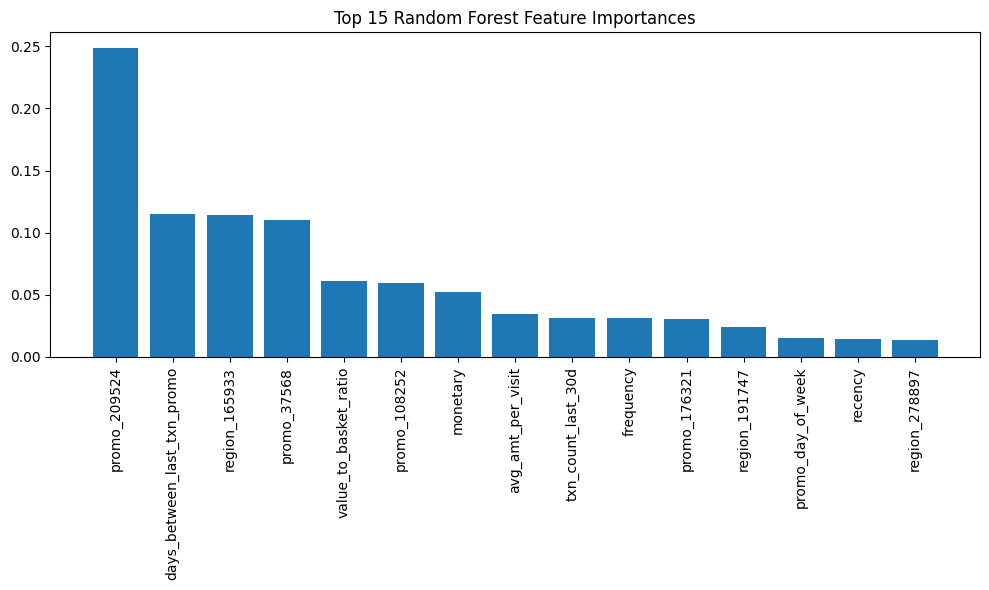

In [99]:
# Get feature importances and names
# Extract the Random Forest model from pipeline
rf_model = best_rf.named_steps['rf']

# Get feature importances and names
feat_imp_rf = rf_model.feature_importances_
feat_names_rf = X_val.columns.tolist()

# Sort and select top 15
indices_rf = np.argsort(feat_imp_rf)[::-1][:15]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(15), feat_imp_rf[indices_rf])
plt.xticks(range(15), [feat_names_rf[i] for i in indices_rf], rotation=90)
plt.title('Top 15 Random Forest Feature Importances')
plt.tight_layout()
plt.show()



### XGBoost

In [100]:
# compute ratio
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos


pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler()),
    ('xgb', XGBClassifier(
         objective='binary:logistic',
         eval_metric='auc',
         random_state=42,
         n_jobs=-1,
         scale_pos_weight=scale_pos_weight
    ))
])

xgb_param_grid = {
    'xgb__n_estimators': [100, 200,400,700],
    'xgb__max_depth': [3, 5, 10],
    'xgb__learning_rate': [0.01, 0.05, 0.1,0.2],
    'xgb__min_child_weight': [1, 5],
    'xgb__colsample_bytree': [0.4,0.7, 1.0]
}
xgb_grid = GridSearchCV(
    pipe,
    xgb_param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scale', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      feature_types=None,
                                                      gamma=None,
                                                      gr...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.4, 0.7, 1.0],
                         'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'xgb__max_depth': [3, 5, 10],
                         'xgb__min_child_weight': [1, 5],
                         'xgb__n_estimators': [100, 200, 400, 700]},
             scoring='roc_auc', verbose=1)

In [101]:
best_xgb = xgb_grid.best_estimator_
print("Best XGB Params:", xgb_grid.best_params_)
xgb_val_proba = best_xgb.predict_proba(X_val)[:, 1]
print(f"XGBoost ROC AUC: {roc_auc_score(y_val, xgb_val_proba):.4f}")


Best XGB Params: {'xgb__colsample_bytree': 0.4, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 700}
XGBoost ROC AUC: 0.6725


In [102]:
best_xgb.fit(X,y)
xgb_auc = roc_auc_score(y, best_xgb.predict_proba(X)[:,1])
print(f"Full‐data ROC AUC: {xgb_auc:.4f}")

Full‐data ROC AUC: 0.7083


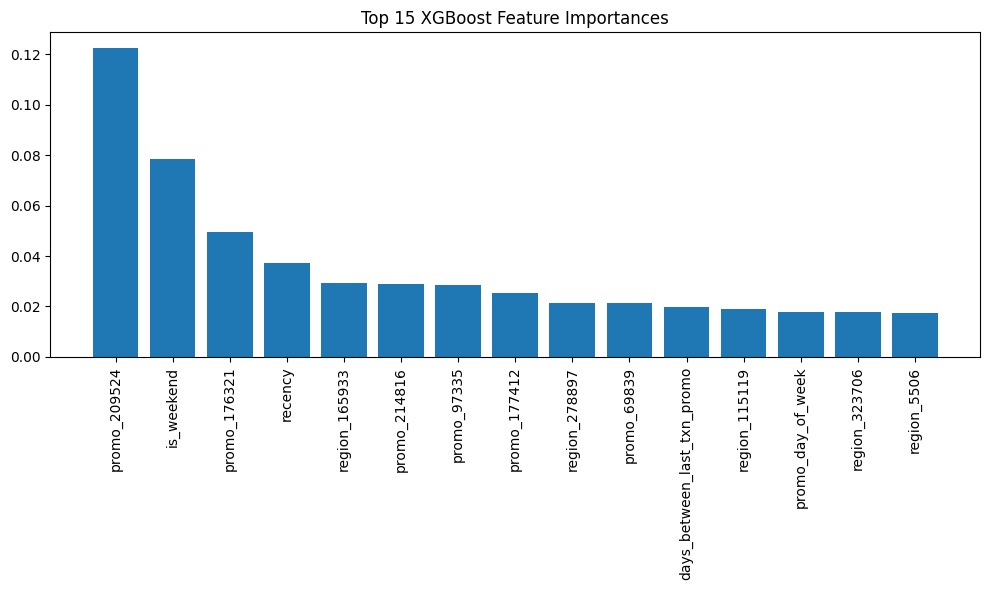

In [103]:
try:
    xgb_model = best_xgb.named_steps['xgb']
except AttributeError:
    xgb_model = best_xgb


feat_imp   = xgb_model.feature_importances_
feat_names = X_val.columns.tolist()

indices = np.argsort(feat_imp)[::-1][:15]


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(15), feat_imp[indices])
plt.xticks(range(15), [feat_names[i] for i in indices], rotation=90)
plt.title('Top 15 XGBoost Feature Importances')
plt.tight_layout()
plt.show()


# Generate Prediction

In [104]:
def build_promo_features(df, transactions):
    tx = transactions.copy()
    max_date = tx['date'].max()
    tx['last_purchase_days'] = (max_date - tx['date']).dt.days

    # RFM
    rfm = (
        tx.groupby('id')
          .agg(recency=('last_purchase_days','min'),
               first_date=('date','min'),
               txn_count=('date','nunique'),
               monetary=('amt','sum'))
          .reset_index()
    )
    rfm['frequency'] = (
        rfm['txn_count'] /
        ((max_date - rfm['first_date']).dt.days.clip(lower=1))
    )
    rfm.drop(columns=['first_date','txn_count'], inplace=True)

    # Other aggregates
    visits    = tx.groupby(['id','date'])['amt'].sum().reset_index()
    avg_amt   = visits.groupby('id')['amt'].mean().rename('avg_amt_per_visit').reset_index()
    tot_txns  = tx.groupby('id').size().rename('total_txns').reset_index()
    tot_amt   = tx.groupby('id')['amt'].sum().rename('total_amt').reset_index()
    store_div = tx.groupby('id')['store'].nunique().rename('num_stores_visited').reset_index()

    # Merge aggregates
    df = (df
          .merge(rfm,      on='id', how='left')
          .merge(avg_amt,  on='id', how='left')
          .merge(tot_txns, on='id', how='left')
          .merge(tot_amt,  on='id', how='left')
          .merge(store_div,on='id', how='left')
         ).fillna(0)

    # Days between last txn & promo
    last_txn = tx.groupby('id')['date'].max().rename('last_txn_date').reset_index()
    df = df.merge(last_txn, on='id', how='left')
    df['days_between_last_txn_promo'] = (
        (df['promodate'] - df['last_txn_date']).dt.days.fillna(-1).astype(int)
    )
    df.drop(columns=['last_txn_date'], inplace=True)

    # Promo‑to‑basket ratio
    df['promo_value_to_basket_ratio'] = (
        df['promoval'] / df['avg_amt_per_visit']
    ).replace([np.inf, -np.inf], 0).fillna(0)

    # Recent 30‑day activity
    promo_map = df[['id','promodate']]
    txn_promo = tx.merge(promo_map, on='id', how='left')
    txn_promo['days_before_promo'] = (txn_promo['promodate'] - txn_promo['date']).dt.days

    recent30 = (
        txn_promo
        .query('0 <= days_before_promo <= 30')
        .groupby(['id','promodate'])
        .size()
        .rename('txn_count_last_30d')
        .reset_index()
    )
    df = df.merge(recent30, on=['id','promodate'], how='left')
    df['txn_count_last_30d'] = df['txn_count_last_30d'].fillna(0).astype(int)

    # Weekend flag
    df['promo_day_of_week'] = df['promodate'].dt.dayofweek
    df['is_weekend']        = (df['promo_day_of_week'] >= 5).astype(int)

    # One‑hot promo & region
    df = pd.concat([
        df,
        pd.get_dummies(df['promo'],  prefix='promo'),
        pd.get_dummies(df['region'], prefix='region')
    ], axis=1)

    return df


# Merge your promos lookup
train = train_history.merge(promos, on="promo", how="left")
test  = test_history .merge(promos, on="promo", how="left")

# Build features
train_feat = build_promo_features(train, transactions)
test_feat  = build_promo_features(test,  transactions)

# Define your final feature set (no RFECV)
keep_feats  = [
    'recency', 'frequency', 'monetary',
    'avg_amt_per_visit',
    'days_between_last_txn_promo',
    'is_weekend',
    'txn_count_last_30d',
    'promo_value_to_basket_ratio'
]
dummy_feats = [c for c in train_feat.columns if c.startswith('promo_') or c.startswith('region_')]
feature_cols = keep_feats + dummy_feats


In [105]:
# Train your tuned Random Forest on all features
X_train = train_feat[feature_cols]
y_train = train_feat['active']

best_rf.fit(X_train, y_train)

full_auc = roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1])
print(f"Full‐data ROC AUC: {full_auc:.4f}")

Full‐data ROC AUC: 0.7079


In [106]:
X_test = test_feat.reindex(columns=feature_cols, fill_value=0)

# Make final predictions
test_feat['pred_proba_active'] = best_rf.predict_proba(X_test)[:,1]
test_feat['pred_active']       = best_rf.predict(X_test)

# then merge back
test_history = test_history.merge(
    test_feat[['id','promodate','pred_proba_active','pred_active']],
    on=['id','promodate'], how='left'
)


In [107]:
test_history[['id', 'pred_active', 'pred_proba_active']].head()

,id,pred_active,pred_proba_active
0,250462324156,1.0,0.505013
1,61214568335,0.0,0.386884
2,274776763999,0.0,0.442731
3,91546215019,0.0,0.449438
4,220718580189,0.0,0.423784


In [108]:
# select & rename
export_df = test_history[['id', 'pred_active']].rename(columns={'pred_active': 'active'})

# export to Excel
export_df.to_excel('final_predictions.xlsx', index=False)